### Import

In [14]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation


In [15]:
train_data = np.load('train_data.npy')
tr_label = np.load('train_label.npy')
test_data = np.load('test_data.npy')
ts_label = np.load('test_label.npy')

print("shape of tran_data is {} and of tran_label is {}".format(train_data.shape, tr_label.shape))
print("shape of test_data is {} and of test_label is {}".format(test_data.shape, ts_label.shape))

data_stats = {
    'Minimum': np.min(train_data),
    'Maximum': np.max(train_data),
    'Mean': np.mean(train_data),
    'Standard Deviation': np.std(train_data),
    "label example" : tr_label[:10]
}

data_stats

shape of tran_data is (50000, 128) and of tran_label is (50000, 1)
shape of test_data is (10000, 128) and of test_label is (10000, 1)


{'Minimum': -23.41520966868848,
 'Maximum': 25.581360537720347,
 'Mean': -1.593740250882547e-14,
 'Standard Deviation': 1.1688636581970187,
 'label example': array([[6],
        [9],
        [9],
        [4],
        [1],
        [1],
        [2],
        [7],
        [8],
        [3]], dtype=uint8)}

In [16]:
def convert_to_one_hot(labels, num_classes):
    # Create an array of zeros with shape (num_samples, num_classes)
    one_hot_labels = np.zeros((labels.size, num_classes))
    
    # Use numpy advanced indexing to set the appropriate elements to one
    one_hot_labels[np.arange(labels.size), labels.flatten()] = 1
    
    return one_hot_labels

train_label = convert_to_one_hot(tr_label, 10)
test_label = convert_to_one_hot(ts_label, 10)

# train_label = train_label * 0.8 + (1 - train_label) * 0.2
# train_label[:10]


In [17]:
# create a activation class
# for each time, we can initiale a activation function object with one specific function
# for example: f = Activation("tanh")  means we create a tanh activation function.
# you can define more activation functions by yourself, such as relu!

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)
    def __tanh_deriv(self, a):
        # a = np.tanh(x)
        return 1.0 - a**2
    
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    def __logistic_deriv(self, a):
        # a = logistic(x)
        return  a * (1 - a )
    
    def __ReLU(self, x):
        return np.maximum(0,x)
    def __ReLU_deriv(self, a):
        #a = ReLU(x)
        return np.where(a > 0, 1, 0)
    
    def __softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)
    def __softmax_deriv(self, x):
        pass

    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'ReLU':
            self.f = self.__ReLU
            self.f_deriv = self.__ReLU_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv


In [18]:
# now we define the hidden layer for the mlp
# for example, h1 = HiddenLayer(10, 5, activation="tanh") means we create a layer with 10 dimension input and 5 dimension output, and using tanh activation function.
# notes: make sure the input size of hiddle layer should be matched with the output size of the previous layer!

class HiddenLayer(object):
    def __init__(self,n_in, n_out,
                 activation_last_layer='softmax',activation='ReLU', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden layer
        """
        self.input=None
        self.activation=Activation(activation).f 

        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # apply HE initialization
        self.W = np.random.randn(n_in, n_out) * np.sqrt(2. /n_in)

        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)

        # we set he size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)


    # the forward and backward progress (in the hidden layer level) for each training epoch
    # please learn the week2 lec contents carefully to understand these codes.
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output

    def backward(self, delta, output_layer=False):

        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = delta
        if self.activation_deriv is not None:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        else:
            delta = delta.dot(self.W.T)
        return delta




In [19]:
class MLP:
    """
    """

    # for initiallization, the code will create all layers automatically based on the provided parameters.
    def __init__(self, layers, activation=[None,'ReLU','softmax']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """
        ### initialize layers
        self.layers=[]
        self.params=[]

        self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))

    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output

    def Cross_Entropy(self,y,y_hat, epsilon = 1e-12):
        # Ensure the predictions are within the range (epsilon, 1-epsilon) for numerical stability
        y_hat = np.clip(y_hat, epsilon, 1. - epsilon)
        # Compute cross-entropy loss for each class and sum
        cross_entropy = -np.sum(y * np.log(y_hat))
        # Calculate the gradient for the output layer
        delta = y_hat - y
        return cross_entropy, delta
                        
            
    # backward progress
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!   

    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X,y,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)

        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])

                # forward pass
                y_hat = self.forward(X[i])

                # backward pass
                # loss[it],delta=self.criterion_MSE(y[i],y_hat)
                loss[it],delta=self.Cross_Entropy(y[i],y_hat)
                self.backward(delta)
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    def predict(self, x):
        x = np.array(x)
        num_samples = x.shape[0]
        num_classes = self.layers[-1].W.shape[1]  
        output = np.zeros((num_samples, num_classes))
        for i in range(num_samples):
            output[i] = self.forward(x[i])
        return output



loss:1.851224


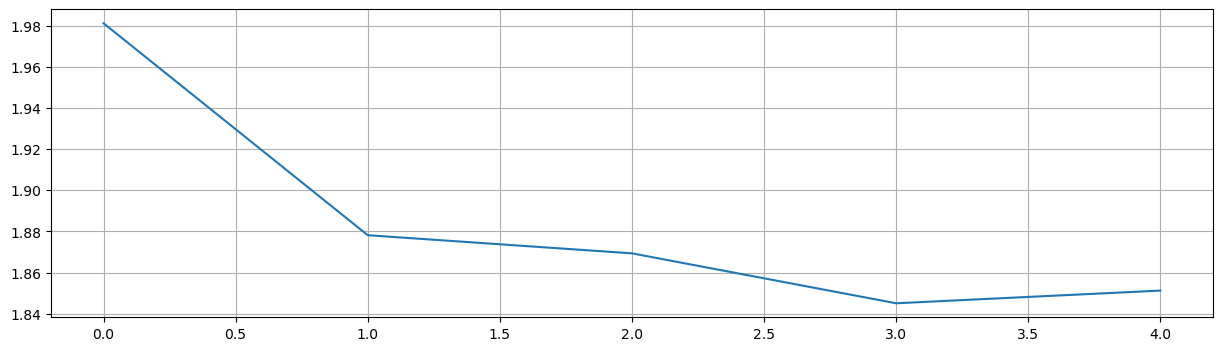

In [20]:
### Try different MLP models
# we can compare the loss change graph to under how the network parameters (such as number of layers and activation functions),
# could affect the performance of network.
nn = MLP([128,512,256,10], [None,'tanh','tanh','softmax'])
input_data = train_data
output_data = train_label
CE = nn.fit(input_data, output_data, learning_rate=0.01, epochs=5)
print('loss:%f'%CE[-1])
pl.figure(figsize=(15,4))
pl.plot(CE)
pl.grid()

In [21]:
output = nn.predict(test_data)
# 将预测概率转换为类别索引
predicted_classes = np.argmax(output, axis=1)
true_classes = np.argmax(test_label, axis=1)

# 计算准确率
accuracy = np.mean(predicted_classes == true_classes)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Test Accuracy: 40.55%
